# Analysis of experimentally measured beam loss

The beam loss at injection shall be compared to the theoretical expectation. 

Let $I_F$ be the intensity of the beam at time $T_F$ the end of INJECTION (beginning of PREPARE RAMP) and $\Delta I_i$ the intensity injected at the injection step $i$. The time of injection at the step $i$ is denoted as $T_i$. Assuming that all losses are caused by dynamic aperture, the final intensity is related to the injected intensity as 

$$ I_F = 2 \, \sum_{i=0}^N \, \Delta I_i \, \int_{D(T_F-T_i)}^{\infty} \rho(x) \, dx \, ,$$

where $\rho(x)$ is the transverse particle distribution, $D(T_F-T_i)$ is the dynamic aperture for the injected bunch at the end of INJECTION and $N$ is the number of injection steps. We are interested in relative losses, so we are going to compare the quantity

$$ r = \frac{\sum_i^N \Delta I_i - I_F}{\sum_i^N \Delta I_i} \, .$$

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytimber as pt
import time
from __future__ import print_function
import sixdesk.dist as dist
from sixdesk.da import beamloss
import sixdesk.da as da
bl = beamloss()

plt.style.use('ggplot')

# fig = plt.figure(figsize=[12,9])
font = {'size'   : 15}
import matplotlib
matplotlib.rc('font', **font)

## Analyze the 2016 runs

In [2]:
fills  = pd.read_csv('fills_2016.csv',usecols=[0],names=['fill'],skiprows=1) # all fills in 2016 in stable beams
fills  = np.array(fills['fill'])

## Load the database and find variables if needed

In [3]:
db = pt.LoggingDB()

In [4]:
b1intensity = 'LHC.BCTDC.A6R4.B1:BEAM_INTENSITY'
b2intensity = 'LHC.BCTDC.B6R4.B2:BEAM_INTENSITY'
lhc_energy  = 'LHC.BQSH.B1:ENERGY'
beam_mode   = 'LHC.CISG.CCR.A:BEAM_MODE'
chroma      = 'LHC.BOFSU:CHROMA_B1_H'
emit1x      = 'LHC.BQSH.B1:NORM_EMITTANCE_BSRT'
emit2x      = 'LHC.BQSH.B2:NORM_EMITTANCE_BSRT'
emit1v      = 'LHC.BQSV.B1:NORM_EMITTANCE_BSRT'
emit2v      = 'LHC.BQSV.B2:NORM_EMITTANCE_BSRT'

In [5]:
def get_injection_phases(fill_number):
    '''Get the time stamps of the beginning and end of the injection phase for a given fill.'''
    data = db.getLHCFillData(fill_number)['beamModes']
    for j in data:
        if j['mode']=='INJPHYS':
            return j['startTime'], j['endTime']

In [6]:
def _get_raw_injection_times(dataset,thresh=0.005e14):    
    time_array, intensity_array = dataset
    indices = np.diff(intensity_array)>thresh
    indices = np.append(indices, False)
    return time_array[indices], intensity_array[indices]

def get_injection_times(dataset, thresh=0.005e14):
    injection_times, injection_intensity = _get_raw_injection_times(dataset,thresh=thresh)
    
    steps_indices   = np.diff(injection_times)>2.      # use only steps which are more than 2 seconds apart from another
    steps_indices   = np.append(steps_indices, True)
    
    injection_intensity = injection_intensity[steps_indices]
    injection_times     = injection_times[steps_indices]
    return injection_times, injection_intensity


def get_delta_i(dataset):
    time_steps, intensity_steps    = get_injection_times(dataset)
    time_injection, data_injection = dataset
    output = []
    for n in range(len(time_steps)):
        int_before_step = data_injection[time_injection <= time_steps[n]+5]
        output.append([time_steps[n], intensity_steps[n], int_before_step[-1] - int_before_step[-10]])
    return pd.DataFrame(output,columns=['time','intensity_before_injection','injected_intensity'])

def get_experimental_beam_loss(dataset):
    injected_beam = get_delta_i(dataset)
    times_to_eoi  = get_time_to_prepare_ramp(dataset)
    
    return (injected_beam['injected_intensity'].sum()-dataset[1][-1])/injected_beam['injected_intensity'].sum()

def get_time_to_prepare_ramp(dataset):
    return dataset[0][-1] - get_delta_i(dataset)['time']

def get_simulated_loss(data, fit_params, realizations):
    
    injected_beam = get_delta_i(data)
    times_to_eoi  = get_time_to_prepare_ramp(data)    
    
    total_intensity = (1 - bl.loss_from_fit_params(fit_params, 
                                                   time=times_to_eoi[0], 
                                                   realizations=realizations))*injected_beam['injected_intensity'][0]
    
    for j in range(1,len(times_to_eoi)):
        total_intensity = total_intensity + (1 - bl.loss_from_fit_params(fit_params, 
                                                                         time=times_to_eoi[j], 
                                                                         realizations=realizations))*injected_beam['injected_intensity'][j]
    return (sum(injected_beam['injected_intensity'])-total_intensity)/sum(injected_beam['injected_intensity'])

## Analyze the past runs 
### Beam 1

Load the data for 2016 and calculate the observed beam loss between the first injection and the beginning of PREPARE RAMP. First initialize the dynamic aperture simulations and get the fit parameters for three different chromaticities.

In [45]:
dbname = '/media/phermes/local/DA_studies/injection_2016/db/lhc_b1_inj_2016_qp_{0}_ioct_{1}.db'
a1 = da.davst(dbname.format(20,40), 2.2)
b1 = da.davst(dbname.format(18,40), 2.2)
c1 = da.davst(dbname.format(16,40), 2.2)

a1.fit_params = a1.fit_params.append(b1.fit_params)
a1.fit_params = a1.fit_params.append(c1.fit_params)
a1.fit_params = a1.fit_params.reset_index(drop=True)

dbname = '/media/phermes/local/DA_studies/injection_2016/db/lhc_b2_inj_2016_qp_{0}_ioct_{1}.db'
a2 = da.davst(dbname.format(20,40), 2.2)
b2 = da.davst(dbname.format(18,40), 2.2)
c2 = da.davst(dbname.format(16,40), 2.2)

a2.fit_params = a2.fit_params.append(b2.fit_params)
a2.fit_params = a2.fit_params.append(c2.fit_params)
a2.fit_params = a2.fit_params.reset_index(drop=True)

def get_loss_from_da(a, seconds):
    a.get_extrapolated_da(seconds=seconds,realizations=10)
    daseries = a.extrapolated_da['exda_{0}_sec'.format(seconds)]
    return bl.get_loss_from_da_series(daseries)

## Read losses for B1

In [18]:
import sqlite3

In [23]:
simloss1, outputb1 = np.array([]), []
for i, fill in enumerate(fills[2:]):
    try:
        start, end      = get_injection_phases(fill)
        data            = db.get([b1intensity],start,end)
        experimental    = get_experimental_beam_loss(data[b1intensity])
        length          = end-start
        print('{0}/{1} Fill number: {2}'.format(i,len(fills[2:]),fill), end='\r')
        if (experimental>0) & (experimental<0.05):
            outputb1.append([fill,experimental,length])
            loss = get_loss_from_da(a1, int(length))
            simloss1 = np.append(simloss1, loss)
    except IndexError:
        pass
outputb1 = pd.DataFrame(outputb1,columns=['fill','experimental','duration'])

/home/phermes/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 1
  del sys.path[0]


In [43]:
simloss1 = simloss

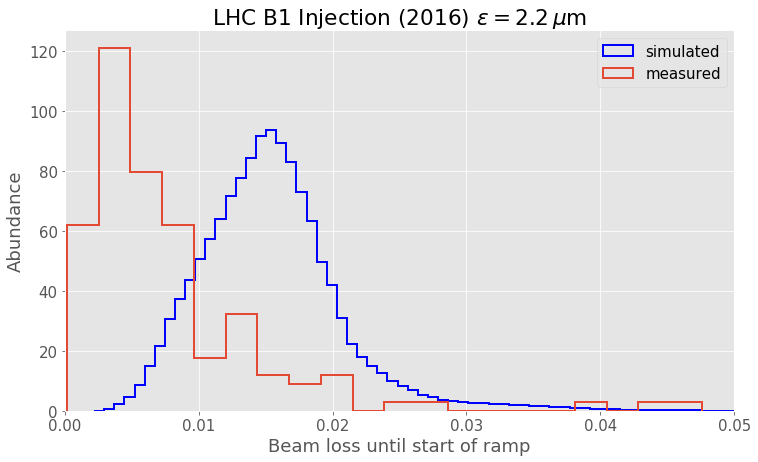

In [44]:
fig = plt.figure(figsize=[12,7])
plt.hist(simloss1,bins=100,normed=True,histtype='step',label='simulated',color='blue',lw=2)
plt.hist(outputb1['experimental'],normed=True,histtype='step',bins=20, label='measured',lw=2)
plt.title(r'LHC B1 Injection (2016) $\epsilon=2.2\,\mu$m')
plt.xlabel('Beam loss until start of ramp')
plt.ylabel('Abundance')
plt.legend()
plt.xlim(0,0.05)
plt.show()

In [49]:
simloss2, outputb2 = np.array([]), []
for i, fill in enumerate(fills[2:]):
    try:
        start, end      = get_injection_phases(fill)
        data            = db.get([b2intensity],start,end)
        experimental    = get_experimental_beam_loss(data[b2intensity])
        length          = end-start
        print('{0}/{1} Fill number: {2}'.format(i,len(fills[2:]),fill), end='\r')
        if (experimental>0) & (experimental<0.05):
            outputb2.append([fill,experimental,length])
            loss = get_loss_from_da(a2, int(length))
            simloss2 = np.append(simloss2, loss)
    except IndexError:
        pass
outputb2 = pd.DataFrame(outputb2,columns=['fill','experimental','duration'])

/home/phermes/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 1
  del sys.path[0]


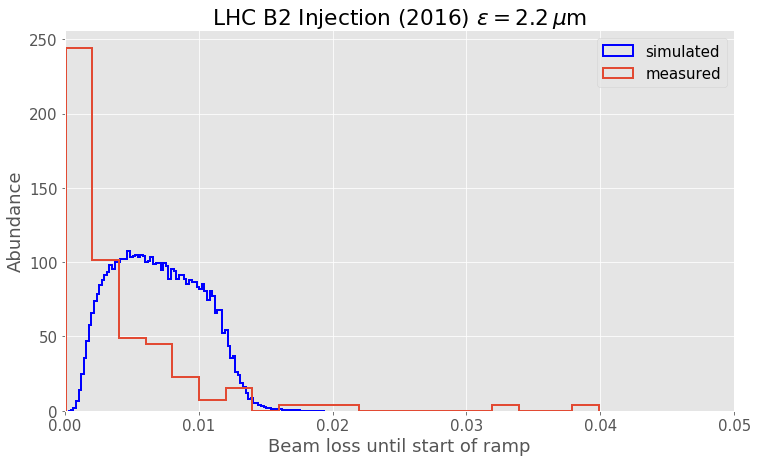

In [52]:
fig = plt.figure(figsize=[12,7])
plt.hist(simloss2,bins=100,normed=True,histtype='step',label='simulated',color='blue',lw=2)
plt.hist(outputb2['experimental'],normed=True,histtype='step',bins=20, label='measured',lw=2)
plt.title(r'LHC B2 Injection (2016) $\epsilon=2.2\,\mu$m')
plt.xlabel('Beam loss until start of ramp')
plt.ylabel('Abundance')
plt.legend()
plt.xlim(0,0.05)
plt.show()

# ATS 2017

In [70]:
dbname = '/media/phermes/local/DA_studies/ats2017/db/ats2017_b1_QP_{0}_IOCT_{1}.db'
a1 = da.davst(dbname.format(20,40), 2.2)
b1 = da.davst(dbname.format(18,40), 2.2)
c1 = da.davst(dbname.format(16,40), 2.2)

a1.fit_params = a1.fit_params.append(b1.fit_params)
a1.fit_params = a1.fit_params.append(c1.fit_params)
a1.fit_params = a1.fit_params.reset_index(drop=True)

dbname = '/media/phermes/local/DA_studies/ats2017/db/ats2017_b2_QP_{0}_IOCT_{1}.db'
a2 = da.davst(dbname.format(20,40), 2.2)
b2 = da.davst(dbname.format(18,40), 2.2)
c2 = da.davst(dbname.format(16,40), 2.2)

a2.fit_params = a2.fit_params.append(b2.fit_params)
a2.fit_params = a2.fit_params.append(c2.fit_params)
a2.fit_params = a2.fit_params.reset_index(drop=True)

def get_loss_from_da(a, seconds):
    a.get_extrapolated_da(seconds=seconds,realizations=10)
    daseries = a.extrapolated_da['exda_{0}_sec'.format(seconds)]
    return bl.get_loss_from_da_series(daseries)

In [75]:
df = pd.read_csv('/home/phermes/Desktop/exportedCSV-1.csv')
fills = df['Fill Number']

In [76]:
simloss1, outputb1 = np.array([]), []
for i, fill in enumerate(fills[2:]):
    try:
        start, end      = get_injection_phases(fill)
        data            = db.get([b1intensity],start,end)
        experimental    = get_experimental_beam_loss(data[b1intensity])
        length          = end-start
        print('{0}/{1} Fill number: {2}'.format(i,len(fills[2:]),fill), end='\r')
        if (experimental>0) & (experimental<0.05):
            outputb1.append([fill,experimental,length])
            loss = get_loss_from_da(a1, int(length))
            simloss1 = np.append(simloss1, loss)
    except IndexError:
        pass
outputb1 = pd.DataFrame(outputb1,columns=['fill','experimental','duration'])

/home/phermes/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 1
  del sys.path[0]


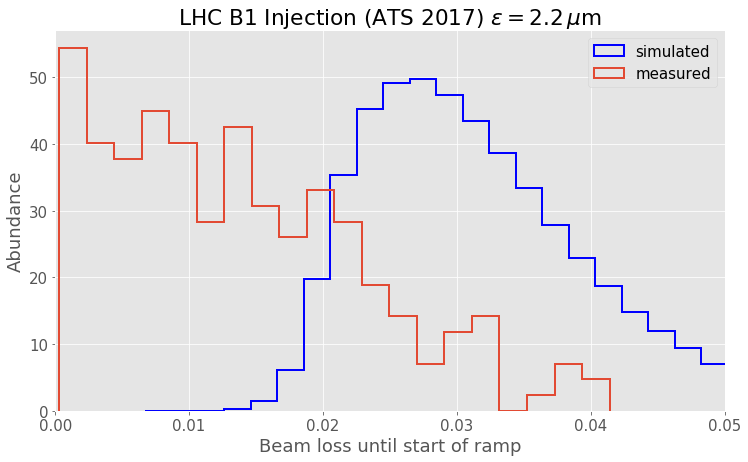

In [78]:
fig = plt.figure(figsize=[12,7])
plt.hist(simloss1,bins=100,normed=True,histtype='step',label='simulated',color='blue',lw=2)
plt.hist(outputb1['experimental'],normed=True,histtype='step',bins=20, label='measured',lw=2)
plt.title(r'LHC B1 Injection (ATS 2017) $\epsilon=2.2\,\mu$m')
plt.xlabel('Beam loss until start of ramp')
plt.ylabel('Abundance')
plt.legend()
plt.xlim(0,0.05)
plt.show()

In [79]:
simloss2, outputb2 = np.array([]), []
for i, fill in enumerate(fills[2:]):
    try:
        start, end      = get_injection_phases(fill)
        data            = db.get([b2intensity],start,end)
        experimental    = get_experimental_beam_loss(data[b2intensity])
        length          = end-start
        print('{0}/{1} Fill number: {2}'.format(i,len(fills[2:]),fill), end='\r')
        if (experimental>0) & (experimental<0.05):
            outputb2.append([fill,experimental,length])
            loss = get_loss_from_da(a2, int(length))
            simloss2 = np.append(simloss2, loss)
    except IndexError:
        pass
outputb2 = pd.DataFrame(outputb2,columns=['fill','experimental','duration'])

/home/phermes/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 1
  del sys.path[0]


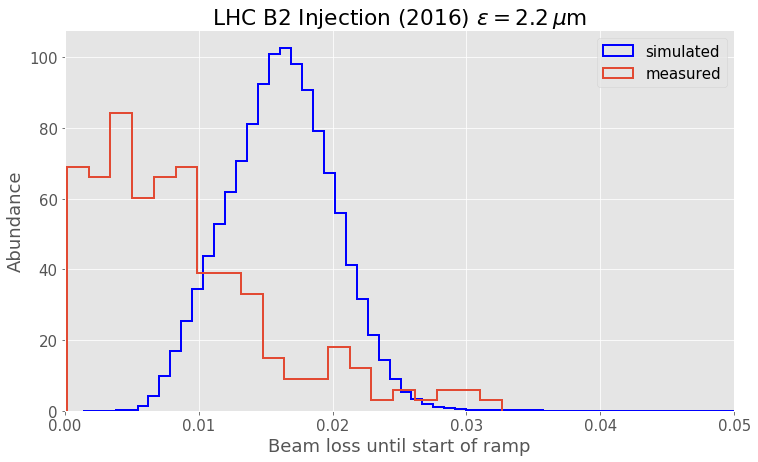

In [80]:
fig = plt.figure(figsize=[12,7])
plt.hist(simloss2,bins=100,normed=True,histtype='step',label='simulated',color='blue',lw=2)
plt.hist(outputb2['experimental'],normed=True,histtype='step',bins=20, label='measured',lw=2)
plt.title(r'LHC B2 Injection (2016) $\epsilon=2.2\,\mu$m')
plt.xlabel('Beam loss until start of ramp')
plt.ylabel('Abundance')
plt.legend()
plt.xlim(0,0.05)
plt.show()

# Use bunch by bunch intensity [DEV]

In [50]:
db.search("LHC.BCTFR.B6R4.B1:BUNCH_INTENSITY")

[u'LHC.BCTFR.B6R4.B1:BUNCH_INTENSITY']

In [51]:
simloss, outputb1 = [], []
for fill in fills[2:]:
    try:
        start, end      = get_injection_phases(fill)
        data            = db.get(["LHC.BCTFR.B6R4.B1:BUNCH_INTENSITY"],start,end)
    except:
        continue
    break

In [55]:
fbct1 = data['LHC.BCTFR.B6R4.B1:BUNCH_INTENSITY']

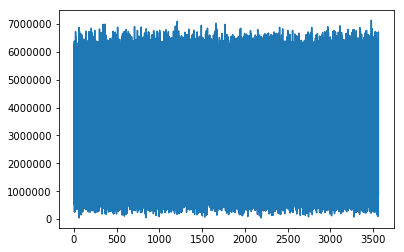

In [61]:
plt.plot(fbct1[1][1])
plt.show()

In [67]:
np.size(fbct1)

ValueError: could not broadcast input array from shape (31,3564) into shape (31)

In [71]:
len(fbct1[0]), len(fbct1[1]), len(fbct1[1][1])

(31, 31, 3564)

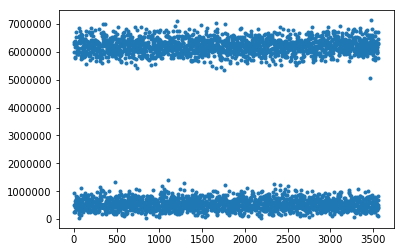

In [75]:
plt.plot(fbct1[1][1],'.')
plt.show()